In [2]:
import os
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import scale
from keras.models import Sequential
from keras.optimizers import SGD, Adam, Adagrad
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Reshape, Activation, Dropout
from keras.layers import Concatenate, Add
from keras.callbacks import ModelCheckpoint
os.chdir('code')
from utils import tf_haversine,get_clusters
from data import load_data
os.chdir('..')

Using TensorFlow backend.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
data = load_data()

In [5]:
data.train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611521 entries, 865212 to 249268
Data columns (total 17 columns):
TRIP_ID                 1611521 non-null int64
CALL_TYPE               1611521 non-null object
ORIGIN_CALL             352694 non-null float64
ORIGIN_STAND            773509 non-null float64
TAXI_ID                 1611521 non-null int64
TIMESTAMP               1611521 non-null datetime64[ns]
POLYLINE                1611521 non-null object
START_LAT               1611521 non-null float64
START_LONG              1611521 non-null float64
QUARTER_HOUR            1611521 non-null float64
DAY_OF_WEEK             1611521 non-null int64
WEEK_OF_YEAR            1611521 non-null int64
DURATION                1611521 non-null int64
ORIGIN_CALL_ENCODED     1611521 non-null int64
TAXI_ID_ENCODED         1611521 non-null int64
ORIGIN_STAND_ENCODED    1611521 non-null int64
POLYLINE_FULL           1611521 non-null object
dtypes: datetime64[ns](1), float64(5), int64(8), object(3)
memor

In [6]:
print ('Train: ',data.train.shape,'\n',
      'Validation: ',data.validation.shape,'\n'
      'Test: ',data.test.shape)

Train:  (1611521, 17) 
 Validation:  (16444, 17) 
Test:  (16445, 17)


In [7]:
data.train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,START_LAT,START_LONG,QUARTER_HOUR,DAY_OF_WEEK,WEEK_OF_YEAR,DURATION,ORIGIN_CALL_ENCODED,TAXI_ID_ENCODED,ORIGIN_STAND_ENCODED,POLYLINE_FULL
865212,1388605269620000325,A,63882.0,NaN,20000325,2014-01-01 19:41:09,"[(41.178807, -8.612568), (41.178789, -8.612676...",41.178807,-8.612568,78.733333,2,0,255,57072,206,0,"[(41.178807, -8.612568), (41.178789, -8.612676..."
196213,1376364767620000108,C,NaN,NaN,20000108,2013-08-13 03:32:47,"[(41.140863, -8.61021), (41.140818, -8.610183)...",41.140863,-8.610210,14.133333,1,32,525,0,78,0,"[(41.140863, -8.61021), (41.140818, -8.610183)..."
1638226,1402931681620000372,B,NaN,36.0,20000372,2014-06-16 15:14:41,"[(41.153895, -8.649702), (41.153724, -8.649963...",41.153895,-8.649702,60.933333,0,24,645,0,239,36,"[(41.153895, -8.649702), (41.153724, -8.649963..."
1401996,1399031635620000167,A,2002.0,NaN,20000167,2014-05-02 11:53:55,"[(41.178222, -8.614134), (41.178123, -8.614089...",41.178222,-8.614134,47.533333,4,17,1050,2,114,0,"[(41.178222, -8.614134), (41.178123, -8.614089..."
1172301,1394627455620000086,C,NaN,NaN,20000086,2014-03-12 12:30:55,"[(41.160951, -8.628822), (41.160861, -8.628579...",41.160951,-8.628822,50.000000,2,10,765,0,65,0,"[(41.160951, -8.628822), (41.160861, -8.628579..."


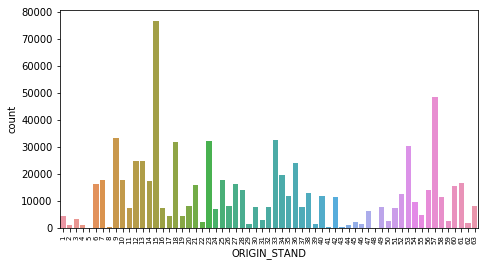

In [8]:
#Feature : Origin_stand
plt.figure(figsize=(7.5,4))
plt.xticks(rotation=90, fontsize=7)
sns.countplot(data.train['ORIGIN_STAND'].dropna().astype(int))
plt.show()

#Numéro 15 et 57 : les deux stations de train de porto : Campanhã et São Bento

In [12]:
100 * pd.notnull(data.train['ORIGIN_STAND']).sum() / float(data.train.shape[0])


47.99869191900075

53% des courses ont démarré autre part qu'à un stand

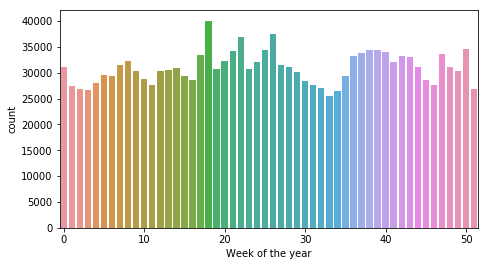

In [16]:
import matplotlib
#Répartition selon la semaine
plt.figure(figsize=(7.5,4))
sns.countplot(data.train['WEEK_OF_YEAR'])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.xlabel('Week of the year')
plt.show()

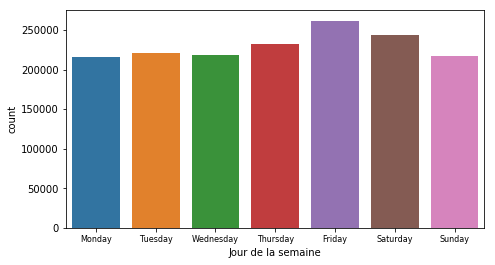

In [19]:
#Par jour de la semaine
import calendar
plt.figure(figsize=(7.5,4))
sns.countplot(data.train['DAY_OF_WEEK'])
plt.gca().set_xticklabels(calendar.day_name)
plt.xticks(fontsize=8)
plt.xlabel('Jour de la semaine')
plt.show()

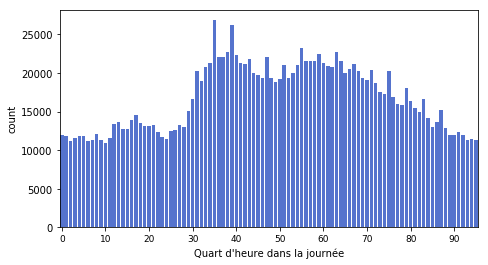

In [26]:
plt.figure(figsize=(7.5,4))
sns.countplot(data.train['QUARTER_HOUR'].apply(int), color='royalblue')
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.xticks(fontsize=9)
plt.xlabel("Quart d'heure dans la journée")
plt.show()

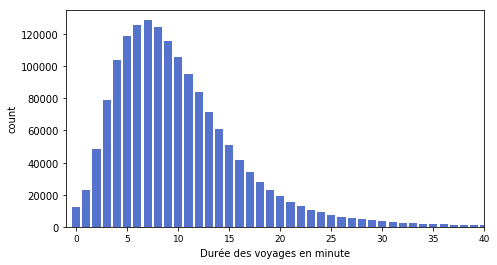

In [28]:
#Durée des voyages
plt.figure(figsize=(7.5,4))
bins = np.arange(60, data.train.DURATION.max(), 60)
binned = pd.cut(data.train.DURATION, bins, labels=bins[:-1]/60, include_lowest=True)
sns.countplot(binned, color='royalblue')
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.xlim(-1, 40)
plt.xticks(fontsize=9)
plt.xlabel('Durée des voyages en minute')
plt.show()

/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


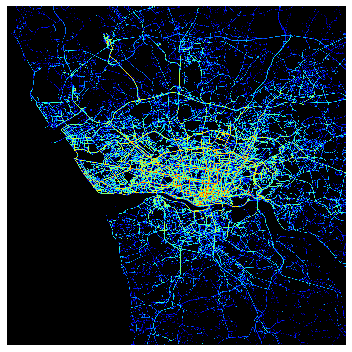

In [150]:
import copy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec


# Coordinates of Porto's city centre
porto = [41.1579, -8.6291]

def density_map(latitudes, longitudes, center=porto, bins=1000, radius=0.1):
    """
    Displays a density map in a matplotlib histogram for all the points
    defined by the given latitudes and longitudes.
    """
    cmap = copy.copy(plt.cm.jet)
    cmap.set_bad((0,0,0))  # Fill background with black

    # Center the map around the provided center coordinates
    histogram_range = [
        [center[1] - radius, center[1] + radius],
        [center[0] - radius, center[0] + radius]
    ]
    
    plt.figure(figsize=(5,5))
    plt.hist2d(longitudes, latitudes, bins=bins, norm=LogNorm(),
               cmap=cmap, range=histogram_range)

    # Remove all axes and annotations to keep the map clean and simple
    plt.grid('off')
    plt.axis('off')
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()
    

all_coords = np.concatenate(data.train['POLYLINE_FULL'].as_matrix())
density_map(all_coords[:,0], all_coords[:,1])

In [94]:
#Points de départ
pt_depart = data.train['POLYLINE_FULL'].apply(lambda x:np.asarray(x[0])).values
pt_depart = np.array(pt_depart.tolist())

In [95]:
#Points d'arrivée
pt_arrivee = data.train['POLYLINE_FULL'].apply(lambda x:np.asarray(x[-1])).values
pt_arrivee = np.array(pt_arrivee.tolist())

In [96]:
os.chdir('code')
from utils import density_map,np_haversine
os.chdir('..')
distances = np_haversine(pt_depart,pt_arrivee)

In [153]:
distances.mean()

3.2433631178339337

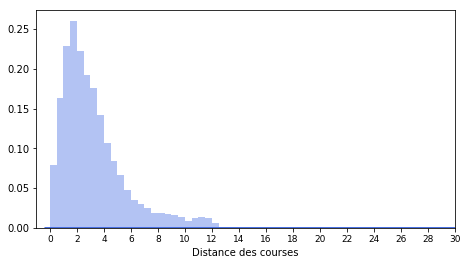

In [158]:
plt.figure(figsize=(7.5,4))
bins = np.arange(0, 20, 0.5)
binned = pd.cut(distances, bins, labels=bins[:-1]*2, include_lowest=True)
sns.distplot(distances,bins=bins, color='royalblue')
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
plt.xlim(-1, 30)
plt.xticks(fontsize=9)
plt.xlabel('Distance des courses')
plt.show()